In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
%matplotlib inline 
%precision 5

u'%.5f'

In [22]:
## Read in a mesh 
meshfile = open("Pmesh_finer.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,3),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])

In [23]:
## reorder the nodes so that the two essential boundary conditions are numbered first
EBC_nodes = []
map_EBC = []
for i in range(n_node):
    nodei_x = node_X[i,:]
    if nodei_x[1]<0.01:
        # bottom boundary node 
        EBC_nodes.append(i)
        map_EBC.append(0)
## sort the EBC ascending order 
EBC_nodes.sort()
## after appending all the nodes in the boundary, exchange one by one with the first few nodes
print('nodes in the EBC boundary',EBC_nodes)
count = 0
for i in range(len(EBC_nodes)):
    if EBC_nodes[i]<len(EBC_nodes):
        map_EBC[i] = EBC_nodes[i]
    else:
        for j in range(len(EBC_nodes)):
            if count==EBC_nodes[j]:
                count+=1
        map_EBC[i] = count
        count+=1
print('map_EBC',map_EBC)


('nodes in the EBC boundary', [0, 1, 4, 8, 13, 19, 27, 36, 46, 58, 59, 72, 88, 105, 123, 139, 159, 176, 196, 216, 236, 254, 274, 275, 294, 314, 316, 339, 362, 384, 405, 428, 452, 477, 505, 533, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575])
('map_EBC', [0, 1, 4, 8, 13, 19, 27, 36, 46, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50])


In [24]:

## do the replacements in node_X and in elements
for i in range(len(EBC_nodes)):
    aux = np.array([node_X[EBC_nodes[i],0],node_X[EBC_nodes[i],1]])
    node_X[EBC_nodes[i],0] = node_X[map_EBC[i],0]
    node_X[EBC_nodes[i],1] = node_X[map_EBC[i],1]
    node_X[map_EBC[i],0] = aux[0]
    node_X[map_EBC[i],1] = aux[1]


for i in range(n_elem):
    node1 = elements[i,0] 
    node2 = elements[i,1] 
    node3 = elements[i,2] 
    try:
        index = EBC_nodes.index(node1)
        elements[i,0] = map_EBC[index]
    except ValueError:
        index = -1
    try:
        index = EBC_nodes.index(node2)
        elements[i,1] = map_EBC[index]
    except ValueError:
        index = -1
    try:
        index = EBC_nodes.index(node3)
        elements[i,2] = map_EBC[index]
    except ValueError:
        index = -1
    try:
        index = map_EBC.index(node1)
        elements[i,0] = EBC_nodes[index]
    except ValueError:
        index = -1
    try:
        index = map_EBC.index(node2)
        elements[i,1] = EBC_nodes[index]
    except ValueError:
        index = -1
    try:
        index = map_EBC.index(node3)
        elements[i,2] = EBC_nodes[index]
    except ValueError:
        index = -1


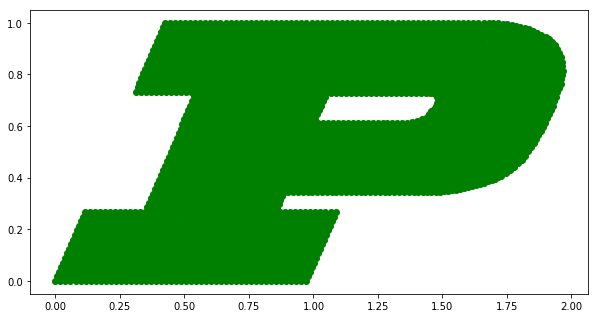

In [25]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
#d = np.zeros((n_node))
plt.triplot(node_X[:,0], node_X[:,1], elements, 'go-')



In [26]:
newfile = open('Pmesh_finer_ordered.txt','w')
newfile.write('Nodes\n')
newfile.write('%i\n'%n_node)
for i in range(n_node):
    newfile.write('%f %f\n'%(node_X[i,0],node_X[i,1]))
newfile.write('Elements\n')
newfile.write('%i\n'%n_elem)
for i in range(n_elem):
    newfile.write('%i %i %i\n'%(elements[i,0]+1,elements[i,1]+1,elements[i,2]+1))
newfile.close()

# Solution

In [27]:
## Read in a mesh 
meshfile = open("Pmesh_finer_ordered.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,3),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
#print(node_X)
#print(elements)

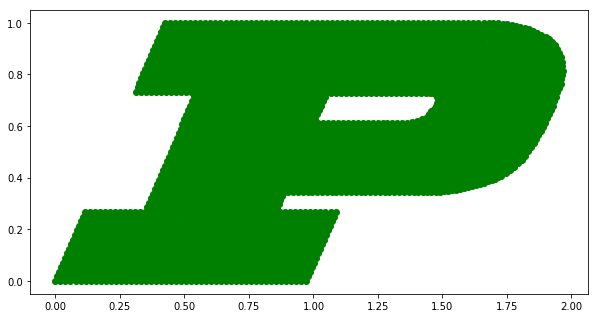

In [28]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
#d = np.zeros((n_node))
plt.triplot(node_X[:,0], node_X[:,1], elements-1, 'go-')

In [29]:
## To build the global stiffness matrix I need to have a function for the 
## gradient of shape functions

def Gradient_N1(x1,y1,x2,y2,x3,y3):
    
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN1dx = (1./(2*A_e))*(y2-y3)
    dN1dy = (1./(2*A_e))*(x3-x2)
    
    return np.array([dN1dx,dN1dy])

def Gradient_N2(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN2dx = (1./(2*A_e))*(y3-y1)
    dN2dy = (1./(2*A_e))*(x1-x3)
    
    return np.array([dN2dx,dN2dy])

def Gradient_N3(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN3dx = (1./(2*A_e))*(y1-y2)
    dN3dy = (1./(2*A_e))*(x2-x1)
    return np.array([dN3dx,dN3dy])

def Area(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    return A_e



In [30]:
## Shape functions over the edge
def N1(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x2e-x)

def N2(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x-x1e)

In [32]:
## Build global stiffness and force vectors
K = np.zeros((n_node*2,n_node*2))
F = np.zeros((n_node*2))

## Loop over elements

# Material properties and other constants
E = 7e10
nu = 0.3
h = 0.2 
rho = 2000

# Traction on the top
tvec = np.array([100,-50])

for i in range(n_elem):
    # Get the nodes making up this element
    node1 = elements[i,0]-1 # the -1 is because indices start from 0
    node2 = elements[i,1]-1 # the -1 is because indices start from 0
    node3 = elements[i,2]-1 # the -1 is because indices start from 0
    node_e = [node1,node2,node3]
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    # Call function to evaluate the gradient of shape functions 
    GradN1e = Gradient_N1(x1,y1,x2,y2,x3,y3)
    GradN2e = Gradient_N2(x1,y1,x2,y2,x3,y3)
    GradN3e = Gradient_N3(x1,y1,x2,y2,x3,y3)
    # Build the element stiffness 
    Ae = Area(x1,y1,x2,y2,x3,y3)
    B = (1./(2.*Ae))*np.array([[y2-y3,0,y3-y1,0,y1-y2,0],
                               [0,x3-x2,0,x1-x3,0,x2-x1],
                               [x3-x2,y2-y3,x1-x3,y3-y1,x2-x1,y1-y2]])
    D = E/(1-nu**2)*np.array([[1.,nu,0.],[nu,1.,0.],[0.,0.,(1.-nu)/2.]])
    Ke = Ae*np.dot(B.transpose(),np.dot(D,B))
    
    #print(Ke)
    # Assemble into the global stiffness 
    for ni in range(3):
        for ncoordi in range(2):
            for nj in range(3):
                for ncoordj in range(2):
                    K[node_e[ni]*2+ncoordi,node_e[nj]*2+ncoordj] += Ke[ni*2+ncoordi,nj*2+ncoordj]
    
    # Integrate the source term. Constant source term so just need to multiply by A/3 
    feb = np.zeros((6))
    feb[1] = (Ae/3.)*rho*h*(-9.8)
    feb[3] = (Ae/3.)*rho*h*(-9.8)
    feb[5] = (Ae/3.)*rho*h*(-9.8)
    
    # Integrate the boundary term for top boundary
    # Constant traction so integral is just multiply by length_edge/2
    fet = np.zeros((6))
    if y1>0.99 and y2 >0.99:
        #print('edge 1-2 of element %i is in the top boundary'%i)
        # first edge is in the top NBC
        le = x1-x2
        Jedge = le/2.
        fet[0] = Jedge*tvec[0]
        fet[1] = Jedge*tvec[1]
        fet[2] = Jedge*tvec[0]
        fet[3] = Jedge*tvec[1]
    if y2>0.99 and y3 >0.99:
        # second edge is in the bottom NBC
        #print('edge 2-3 of element %i is in the top boundary'%i)
        le = x2-x3
        Jedge = le/2.
        fet[2] = Jedge*tvec[0]
        fet[3] = Jedge*tvec[1]
        fet[4] = Jedge*tvec[0]
        fet[5] = Jedge*tvec[1]
    if y3>0.99 and y1 >0.99:
        # third edge is in the top NBC
        #print('edge 3-1 of element %i is in the top boundary'%i)
        le = x3-x1
        Jedge = le/2.
        fet[0] = Jedge*tvec[0]
        fet[1] = Jedge*tvec[1]
        fet[4] = Jedge*tvec[0]
        fet[5] = Jedge*tvec[1]
            
    # Assemble into the global force
    for ni in range(3):
        for ncoordi in range(2):
            F[node_e[ni]*2+ncoordi]+=feb[ni*2+ncoordi]+fet[ni*2+ncoordi]

In [33]:
## To solve we need the essential boundary condition
# create zero vector size of nodes*2
# For the finer mesh the first 51 nodes have EBC

d = np.zeros((n_node*2))
d_E = np.zeros((51*2))


In [34]:
n_E = 51*2
n_F = n_node-51*2
K_E = K[0:n_E,0:n_E]
K_F = K[n_E:,n_E:]
K_EF = K[0:n_E,n_E:]
F_E = F[0:n_E]
F_F = F[n_E:]
#d_E = d[0:n_E]
#print(F_F)

In [35]:
#solve
d_F = np.linalg.solve(K_F,F_F- np.dot(K_EF.transpose(),d_E))
print(d_F)

[ 6.36291e-09  1.26014e-09  5.68521e-09 ... -2.27442e-06  9.74844e-07
 -2.30132e-06]


In [36]:
# reassemble into full d 
for i in range(n_E,n_node*2):
    d[i] = d_F[i-n_E]
print('min and max x displacement')
print(np.min(d.reshape((n_node,2))[:,0]))
print(np.max(d.reshape((n_node,2))[:,0]))
print('min and max y displacement')
print(np.min(d.reshape((n_node,2))[:,1]))
print(np.max(d.reshape((n_node,2))[:,1]))

min and max x displacement
-8.91792866824185e-08
1.0893290543389549e-06
min and max y displacement
-2.391225658413531e-06
4.6832565050732086e-07


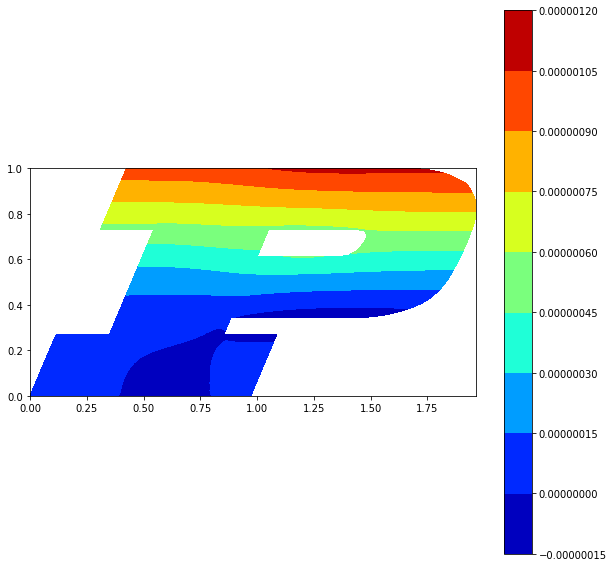

In [37]:
# Plot the x-displacement
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
#levels = [-0.00001, 0.2, 0.4, 0.6, 0.8, 1., 1.2,1.4]
plt.tricontourf(node_X[:,0],node_X[:,1] ,  elements-1, d.reshape((n_node,2))[:,0],cmap='jet')
plt.colorbar()

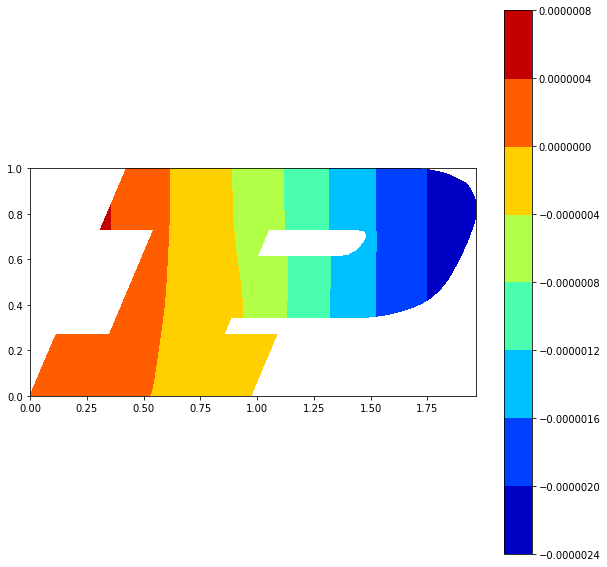

In [38]:
# Plot the y-displacement
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
#levels = [-0.00001, 0.2, 0.4, 0.6, 0.8, 1., 1.2,1.4]
plt.tricontourf(node_X[:,0],node_X[:,1] ,  elements-1, d.reshape((n_node,2))[:,1],cmap='jet')
plt.colorbar()

In [39]:
## Calculate and plot the stresses 
sigma_trivec = np.zeros((n_elem,3))
for i in range(n_elem):
     # Get the nodes making up this element
    node1 = elements[i,0]-1 # the -1 is because indices start from 0
    node2 = elements[i,1]-1 # the -1 is because indices start from 0
    node3 = elements[i,2]-1 # the -1 is because indices start from 0
    node_e = [node1,node2,node3]
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    Ae = Area(x1,y1,x2,y2,x3,y3)
    B = (1./(2.*Ae))*np.array([[y2-y3,0,y3-y1,0,y1-y2,0],
                               [0,x3-x2,0,x1-x3,0,x2-x1],
                               [x3-x2,y2-y3,x1-x3,y3-y1,x2-x1,y1-y2]])
    D = E/(1-nu**2)*np.array([[1.,nu,0.],[nu,1.,0.],[0.,0.,(1.-nu)/2.]])
    
    ## to evaluate the stress need to go get the solution of the displacement
    ue = np.zeros((6))
    for ni in range(3):
        for ncoordi in range(2):
            ue[ni*2+ncoordi] = d[node_e[ni]*2+ncoordi]
    sigma = np.dot(D,np.dot(B,ue))
    sigma_trivec[i,:] = sigma
    
print('min and max sigma_x')
print(np.min(sigma_trivec[:,0]))
print(np.max(sigma_trivec[:,0]))
print('min and max sigma_y')
print(np.min(sigma_trivec[:,1]))
print(np.max(sigma_trivec[:,1]))

min and max sigma_x
-88453.85685721926
35914.3697816195
min and max sigma_y
-154788.52724053155
42370.55553739014


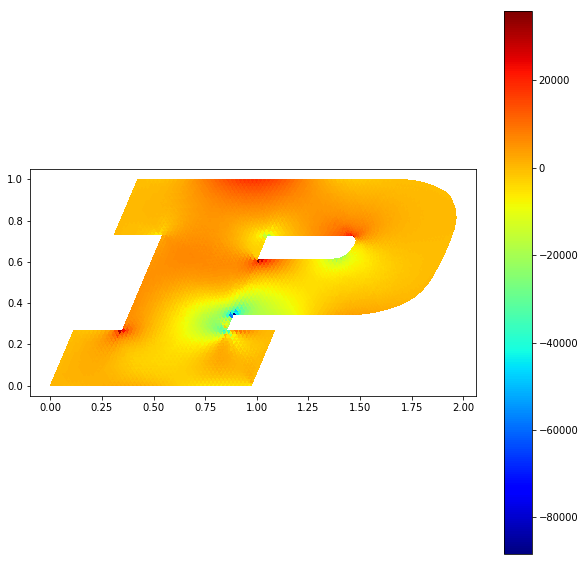

In [40]:

plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
plt.tripcolor(node_X[:,0],node_X[:,1] ,  elements-1, facecolors=sigma_trivec[:,0] ,cmap='jet')
plt.colorbar()

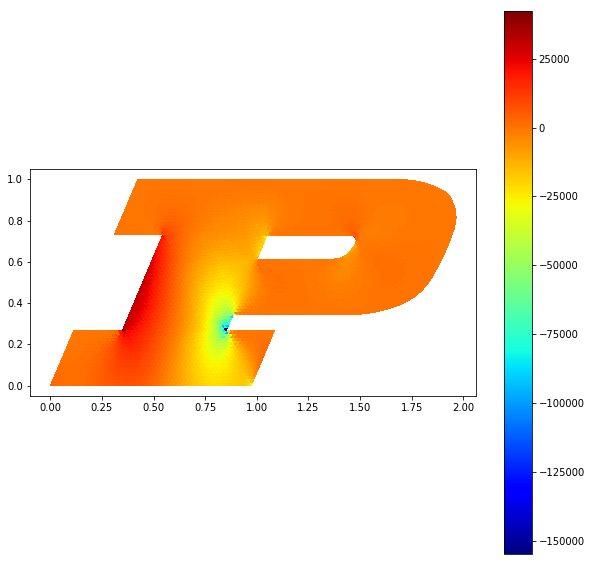

In [41]:

plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
plt.tripcolor(node_X[:,0],node_X[:,1] ,  elements-1, facecolors=sigma_trivec[:,1] ,cmap='jet')
plt.colorbar()

In [9]:
count

51